# Battle of Neighbourhoods - Final

## Overview of the Project##

1. Introduction
2. Data Section
3. Methodology Section
4. Results Section
5. Discussion Section
6. Conclusion Section

## Introduction/ Business Problem

In this project we try to find a optimal location to start Mexican Resturant in the city of Puducherry(Pondicherry), India. Puducherry city, lies in the south-India facing the sea "Bay of Bengal" and is surrounded by the state of Tamil Nadu with which it shares most of its culture and language. Puducherry, once colnized by French is one of unique place in India and attracts many tourist. 

## Opening of Mexican Restaurant

As the city was part of French Territory and still holds French culture, many French and Italian resturants already present there apart from Indian resturants. So,as part of business problem, we wish to find a appropriate location to start a Mexican resturant, so that to attract more tourist. The challenge is to find a suitable location for opening a new hotel / restaurant attracted to all local and foreign people in the centre of the town.

## Data Used

We will be completely working on Foursquare data to explore and try to locate our new hotel where more venues like church, temples, beach, museums, memorials that are present nearby.

##  Importing Libraries

In [58]:
# Import libraries
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation

from sklearn.cluster import KMeans # clustering algorithm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print("Loaded Imported")

Loaded Imported


## Credentials and Core location

In [130]:
CLIENT_ID = 'JXGMBDGIADO4ZUMFCUSGCXSYJN5GSTLCAOLE35BH1WVYYOYG' # your Foursquare ID
CLIENT_SECRET = 'L2VMHH2C1BF1Y5DGV0TCGUCF33ZC5Q0YBCZKV3JETEW0M2M4' # your Foursquare Secret
VERSION = '20200715' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' +CLIENT_SECRET )

Your credentails:
CLIENT_ID: JXGMBDGIADO4ZUMFCUSGCXSYJN5GSTLCAOLE35BH1WVYYOYG
CLIENT_SECRET:L2VMHH2C1BF1Y5DGV0TCGUCF33ZC5Q0YBCZKV3JETEW0M2M4


In [131]:
address = "Puducherry, India"

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude =location.latitude   #11.9340568 # location.latitude 
longitude =location.longitude #79.8306447 # location.longitude # 

Pondy='Puducherry location : {},{}'.format(latitude,longitude)
print(Pondy)

Puducherry location : 11.9340568,79.8306447


## Search for hotel & restaurant in the surroundings

In [229]:
#Quering for hotel & restaurant

search_query = 'Hotel'
search_query_res = 'restaurant'

radius = 1000
url_hotel = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url_restaurant = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_res, radius, LIMIT)
#url

## Send the GET Request of hotel & restaurants and examine the results

In [223]:
results_hotel = requests.get(url_hotel).json()
results_restaurant = requests.get(url_restaurant).json()
#results_hotel

## Get relevant part of JSON and transform it into a pandas dataframe

In [230]:
# assign relevant part of JSON to venues
venues_hotel = results_hotel['response']['venues']
venues_restaurant = results_restaurant['response']['venues']

# tranform venues into a dataframe and merging both data
dataframe_hotel = json_normalize(venues_hotel)
dataframe_restaurant = json_normalize(venues_restaurant)

dataframe = pd.concat([dataframe_hotel,dataframe_restaurant])

print("There are {} restaurants and hotels at Puducherry".format(dataframe.shape[0]))

There are 15 restaurants and hotels at Puducherry


<ipython-input-230-b5b3fdac6805>:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe_hotel = json_normalize(venues_hotel)
<ipython-input-230-b5b3fdac6805>:7: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe_restaurant = json_normalize(venues_restaurant)


## Define information of interest and filter dataframe

In [231]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

    
# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

  
# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

#dataframe_filtered
hotels_df=dataframe_filtered[['name','categories','distance','lat','lng','id']]
hotels_df.head(10)

,name,categories,distance,lat,lng,id
0,Hotel Anand Bhavan,Indian Restaurant,23,11.933870,79.830744,527cfcbc11d263884d47f90d
1,Coramandal Hotel,Boarding House,58,11.933744,79.830208,4fe2cffee4b0c2d9ace0d645
2,hotel jubilee,Indian Restaurant,95,11.934873,79.830925,52f73d14498efbe3f01941b2
3,Hotel Corbelli,Bed & Breakfast,104,11.934967,79.830892,4f3670a1e4b05324680fe207
4,Hotel Aristo,Restaurant,240,11.936140,79.830060,4ea51fde8b81a02f8ab2a2f2
5,Soorya Hotel,Bed & Breakfast,119,11.935131,79.830645,51e02bee498e85c2beeafe8c
6,Hotel Annapoorna,Restaurant,335,11.934570,79.827614,5338da6a498e2f346e588464
7,City Business Hotel,Hotel,288,11.935850,79.828726,58275f7d88a1a041b74d796e
8,Richmond Hotel Puducherry,Indian Restaurant,343,11.931483,79.832391,4bd885b22ecdce723fcbd0f2
9,Kaarthik,Fast Food Restaurant,252,11.935139,79.832681,4ec7794f0e017e2f99e261fe


## Location of Hotels

In [232]:
hotels_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Kanyakumari

# add a red circle marker to represent the core location of kanyakumari
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Puducherry',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(hotels_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(hotels_map)

# display map
hotels_map


## Methodology section

In this sections, we try to perform some data analysis to find insight from data
and understand the current stats of all the given data.


### How Far are hotels from the core location

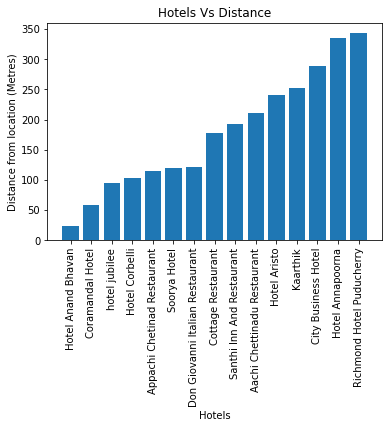

Average distance between hotels and core location is 178 metres


In [233]:
distance_hotel_df=dataframe_filtered[['name','categories','distance','lat','lng']].sort_values('distance')

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(distance_hotel_df.name))
    plt.bar(distance_hotel_df.name, distance_hotel_df.distance)
    plt.xlabel('Hotels')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_hotel_df.name,rotation=90)
    plt.title('Hotels Vs Distance')
    plt.show()
plot_bar_x()

print("Average distance between hotels and core location is {} metres".format(int(sum(hotels_df['distance'])/hotels_df.shape[0])))

### Explore for other venues around Puducherry


 
A tourist person always wants to visit nearby iconic places.So he wants to reside somewhere nearby to all major venues.We will be exploring more venues around the core location.We will be digging more on main areas or place around.


In [170]:
radius=300
url_venues = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
#url_venues

In [171]:
import requests

results_venues = requests.get(url_venues).json()
'There are {} venues around Puducherry.'.format(len(results_venues['response']['groups'][0]['items']))


'There are 12 venues around Puducherry.'

In [172]:
items_venues = results_venues['response']['groups'][0]['items']
#items_venues[0]


In [173]:
dataframe_venues = json_normalize(items_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe_venues.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered_venues = dataframe_venues.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered_venues['venue.categories'] = dataframe_filtered_venues.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered_venues.columns = [col.split('.')[-1] for col in dataframe_filtered_venues.columns]

dataframe_filtered_venues.name

<ipython-input-173-1c6e6f16471d>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe_venues = json_normalize(items_venues) # flatten JSON


0         Don Giovanni Italian Restaurant
1                              Cafe Xtasi
2                          Domino's Pizza
3                               Bon Bakes
4                              Hot Breads
5                           Hidesign cafe
6                                 Surguru
7                              Richy Rich
8                            Hotel Aristo
9                              Casablanca
10    Wangs Kitchen (Formerly China Town)
11                   Nilgiris Supermarket
Name: name, dtype: object

### Extract Venues using Search Queries

When I searched in google map,I could see there were some venues missing.Temples,Church,Parks and Museums are also more recognized by visitors and local audience.So lets bring their data inside.I am not sure why Foursquare hasnt captured it while trying venue query.

Below is the function to extract many queries at a time by passing them in a single list.


In [174]:
# search query function
search_query_list = ['temple','church','park','museum'] 
radius =600
temp_df=[]
search_df=[]

def search_query_fn():   
    #Loop to run through urls and from json to pandas
    for i in range(len(search_query_list)):
        url= 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query_list[i], radius, LIMIT)
        
        results=requests.get(url).json()
        venues = results['response']['venues']
        
        #Normalize from json
        dataframe = json_normalize(venues)
        
        #Removing unwanted column headers
        dataframe.columns = [col.split('.')[-1] for col in dataframe.columns]
        temp_df.append(dataframe)
    
    #Loop to append dataframes to single dataframe
    for j in range(len(search_query_list)):
        data=temp_df[j]
        search_df.append(data)

# Function to run loop over queries
search_query_fn()

search_df = pd.concat(search_df,sort=True)
search_df['categories'] = search_df.apply(get_category_type, axis=1)
search_df = pd.DataFrame(search_df[['name','categories','distance','lat','lng','id']])
search_df


<ipython-input-174-32aacb944798>:16: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,name,categories,distance,lat,lng,id
0,Arulmigu Manakula Vinayagar Temple,Temple,400,11.935932,79.833786,4e1868ceb0fb8567c66bf190
1,Ganapathy Temple,Temple,410,11.936017,79.833835,51fdd3b6498e6da0a4a14e9e
2,Sri Kanika Parameshwari temple,Temple,563,11.939080,79.830033,511afc76e4b01dae781a79aa
0,Domas Church,Church,608,11.929928,79.834307,51fdd98f498ea0097cf260ea
1,Church Gate,Gourmet Shop,66,11.933475,79.830799,4d14affabb64224b59beae65
2,CSI St. John Church,Church,422,11.931057,79.833020,51d80b46498eb3b0f95ffb19
3,Our lady of Angels church,Church,582,11.930130,79.834180,527f1bc711d2bbc52930cdfa
0,Bharathi Park,Park,416,11.932934,79.834294,5014c4e9e4b097af8abacef9
1,French Park,Clothing Store,192,11.935769,79.830910,5c820a4d603d2a002ce459d1
2,Raymond Park Avenue,Men's Store,423,11.934395,79.826774,51e402ce498e6f1752d3add3


In [175]:
# Data extracted from foursquare venues
four_sq_venue=pd.DataFrame(dataframe_filtered_venues[['name','categories','distance','lat','lng','id']])

# Data extracted from search queries
new_venues=pd.DataFrame(search_df)

# Concatenate both dataframe
df_venue=pd.concat([four_sq_venue, new_venues],sort=True)


In [152]:
to_drop = ['Hotel', 'Restautant','hotel','Resort']
df_venues = df_venue[~df_venue['name'].str.contains('|'.join(to_drop))].reset_index()
print("There are {} venues in Puducherry".format(df_venues.shape[0]))
df_venues[['name','distance','id']]

There are 75 venues in Puducherry


,name,distance,id
0,Don Giovanni Italian Restaurant,121,4dc6bdb7d164eb9ca00f0aa6
1,Le Dupleix,481,4e63896fb61cd78089057865
2,Cafe Xtasi,38,4dfb7c502271baece2433cb8
3,Domino's Pizza,94,52459570498e4ebe801c20f4
4,La Villa,492,53e65f6b498e6a14dc2b5518
5,Adyar Ananda Bhavan,304,4cb0174c75ebb60c6adfc1ad
6,Bharathi Park,416,5014c4e9e4b097af8abacef9
7,ZUKA Choco-la,469,50d0323de4b0bcb85621bd31
8,Choco-la,465,4da16e49d686b60c3c2da528
9,The Indian Kaffe Express,609,502d161ce4b0504d9d3d2532


### Location of all venues

In [201]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Conrad Hotel

# add a red circle marker to represent the Puducherry
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Puducherry',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(df_venues.lat, df_venues.lng, df_venues.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        #popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

### How far are venues from the core location?

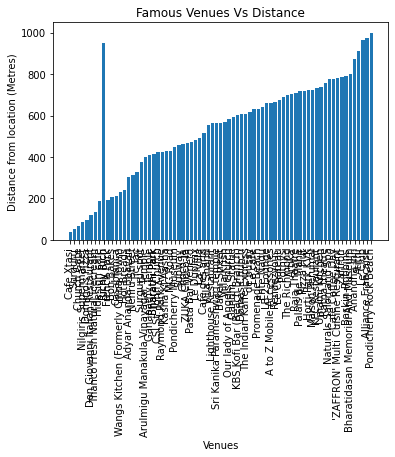

In [177]:
distance_venues_df=df_venues.sort_values('distance')

def plot_bar_venue():
    # this is for plotting purpose
    index = np.arange(len(distance_venues_df.name))
    plt.bar(distance_venues_df.name, distance_venues_df.distance)
    plt.xlabel('Venues')
    plt.ylabel('Distance from location (Metres)')
    plt.xticks(distance_venues_df.name,rotation=90)
    plt.title('Famous Venues Vs Distance')
    plt.show()
plot_bar_venue()

### Venue Categories

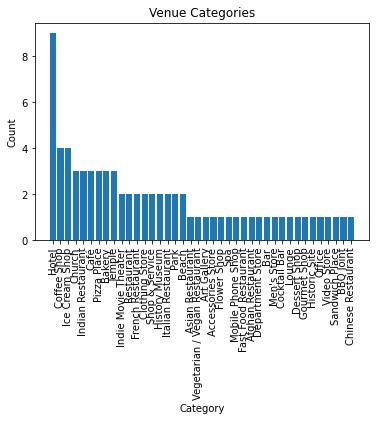

In [178]:
freq_venue=df_venues['categories'].value_counts()
freq_venue=pd.DataFrame(freq_venue).reset_index()
freq_venue.columns=['Category','Count']
freq_venue

def plot_bar_categ():
    # this is for plotting purpose
    index = np.arange(len(freq_venue.Category))
    plt.bar(freq_venue.Category, freq_venue.Count)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(freq_venue.Category,rotation=90)
    plt.title('Venue Categories')
    plt.show()
plot_bar_categ()


### Clustering based on venues

In [191]:
# one hot encoding
neighbor_onehot = pd.get_dummies(df_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
neighbor_onehot['name'] = df_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [neighbor_onehot.columns[-1]] + list(neighbor_onehot.columns[:-1])
neighbor_onehot = neighbor_onehot[fixed_columns]

neighbor_onehot.head()

,name,Accessories Store,Afghan Restaurant,Art Gallery,Asian Restaurant,BBQ Joint,Bakery,Bar,Beach,Café,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Department Store,Dessert Shop,Fast Food Restaurant,Flower Shop,French Restaurant,Gourmet Shop,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Lounge,Men's Store,Mobile Phone Shop,Office,Park,Pizza Place,Restaurant,Sandwich Place,Shop & Service,Spa,Temple,Vegetarian / Vegan Restaurant,Video Store
0,Don Giovanni Italian Restaurant,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Le Dupleix,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Cafe Xtasi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Domino's Pizza,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,La Villa,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [217]:
neighbor_onehot.shape
neighbor_grouped = neighbor_onehot.groupby('name').mean().reset_index()

In [218]:
# Top 10 venues
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['name'] = neighbor_grouped['name']

In [195]:
# Clustering

# set number of clusters
kclusters = 3

neighbor_grouped_clustering = neighbor_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(neighbor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Clustersss', kmeans.labels_)

neighbor_merged = df_venues

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
neighbor_merged = neighbor_merged.join(neighborhoods_venues_sorted.set_index('name'), on='name')

kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [219]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=17)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='green',
    popup='My hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbor_merged['lat'], neighbor_merged['lng'], neighbor_merged['name'], neighbor_merged['Clustersss']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

In [216]:
my_hotel_vs_all = folium.Map(location=[latitude, longitude], zoom_start=16) # generate map centred around the Kanyakumari


# add a red circle marker to represent the my hotel location
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='green',
    popup='My Hotel',
    fill = True,
    fill_color = 'green',
    fill_opacity = 0.6
).add_to(my_hotel_vs_all)


# add a red circle marker to represent the core location of Puducherry
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Puducherry',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(my_hotel_vs_all)

# add the Italian restaurants as blue circle markers
for lat, lng, label in zip(hotels_df.lat, hotels_df.lng, hotels_df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(my_hotel_vs_all)
    
    



# display map
my_hotel_vs_all

The location gives the central point to visit all other venues.Hence this can be locked down to attract all tourist. In this, place new Mexican resturant can be started.

## Discussion section

From above reports,we could get an idea why the predicted one is pointed/clustered on the given spot.First most thing could be the center of attraction for the place.

KMeans have figured out the most common place for all the venues.This output was very adjacent to the core location.This proves the accurate spotting of our predicted algorithm.

Despite of the findings,there were some lack in data.Tips and ratings were missing for most of the venues.Also when I compared foursquare data with google map ,i could see there were many hotels and venues found missing in foursquare.


## Conclusion section

As a business person,one would be able to set up a hotel/restaurant on given spot.This will bring revenue automatically as we have located in very near to core one.We proved this with Kmeans.

### Future Expectation:

As mentioned earlier,most of data needs to be extracted from googlemaps.Even though we got somewhat accurate prediction.To be very confident on concluding our output,we may need more data to analyse.

Research based on hotel reviews and restaurant menus could be used for future purpose.

### My Experience:

It was wonderful journey for me in IBM capstone and other courses.It can aid to layman people as well who dont know a pinch of Data science.Thanks to Coursera for keeping Skilful instructors with their awesome materials

# THANK YOU!!